# Natural Language Processing

## Machine Translation ( from French to Fongbe and Ewe )

In this project, we have to build a model which allow to translate sentences from french to two languages or build a model which translate from french to specific language. In this case, we need to build two models.


# by group 5

## 1. Kouassi Cyril
## 2. Gabriel DOUIF
## 3. Binta Sow
## 4. Okon GodsPower
## 5. Amisi FIKIRINI

In [ ]:
import string
import re
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
tqdm.pandas()
%matplotlib inline
pd.set_option('display.max_colwidth', 400)

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


## 0. Loading Data

In [ ]:
df_train = pd.read_csv("/content/drive/MyDrive/NLP/final_project/Train.csv")
df_test = pd.read_csv("/content/drive/MyDrive/NLP/final_project/Test.csv")

### Let check size of datas

In [ ]:
print("The data train size is : {}".format(df_train.shape))
df_train.tail(3)

The data train size is : (75487, 4)


,ID,French,Target_Language,Target
75484,ID_zztqxmJe,"Si mon mari conduit, c’est que ce n’est pas loin .",Fon,"Nu asu ce kun hun ɔ, hun e lin a nε"
75485,ID_zzxVgzgw,"Cette année, je vais épouser celle-là.",Fon,"Xwe elɔ mɛ, un na wli alɔ x’ɛ"
75486,ID_zzzEhSHN,"Dans une casserole, je la fais fondre dans un litre d'eau chaude.",Fon,"Ɖo ganzɛn kpɛvi mɛ ɔ, un hɛn sinsin ɖo sin zozo litli ɖokpo mɛ"


In [ ]:
print("The data test size is : {}".format(df_test.shape))
df_test.tail(3)

The data test size is : (5893, 3)


,ID,French,Target_Language
5890,ID_zxgfwvGY,"Aujourd’hui, la science n’a pas fini de percer ce mystère pour pouvoir passer un jour, elle en rêve, le relai à certains hommes",Ewe
5891,ID_zyWQSnnG,Il n’a pas rêvé.,Fon
5892,ID_zzxMHWjm,"Après, je suis passé au graff avec la bombe de peinture (spray) à travers des voyages sur des festivals dans les pays limitrophes",Fon


### 0.1. Train Data

In [ ]:
#Checking the number of unique values before to split dataset.
df_train.Target_Language.unique()

array(['Fon', 'Ewe'], dtype=object)

In [ ]:
#reduce data
df_train = df_train.iloc[:5000,]
df_test = df_test.iloc[:2000,]

#### 0.1.1. Let extract Train data for language "Ewe"

In [ ]:
#df_train_ewe = df_train[df_train.Target_Language == 'Ewe']
#df_train_ewe = df_train.iloc[:5000,]
#print("The Ewe Train dataset size is : {}".format(df_train_ewe.shape))
#df_train_ewe.head(10)

### Recall about the general workflow of an NLP System viewed in the course (reference lecture_02)

Process common to all if not most NLP Task :

##### 1. Raw text corpus: like data collection in any ML system
##### 2. Tokenized: corpus reduced to unique tokens
##### 3. Vocabulary: normalized tokens collecting of unique symbols of meaning
##### 4. Text representation: encoding meaning into text
##### 5. NLP task: machine translation (for our case), searching etc.

In context of our work, we are going to split the process in two big steps (Text preprocessing and model buil - test)

## 1. Text Preprocessing

This step is so important because it allow to take care about certains things before building the model because often we are working with data which does not structured.

### 1.1. Text cleaning

As we have seen above, the data contains some ponctuation caracteres. We need to remove its after that we need to convert data (all sentences) in lower case.

In [ ]:
#This function allow to remove the ponctuation caracteres
def remove_ponctuation(X, column_index):
  X.iloc[:,column_index] = [cp.translate(str.maketrans('','', string.punctuation)) for cp in X.iloc[:,column_index].values]
  return X

### Let remove ponctuation for Train Dataset

In [ ]:
remove_ponctuation(df_train, 1)
remove_ponctuation(df_train, 3)

,ID,French,Target_Language,Target
0,ID_AADNDxdl,Mon père,Fon,Tɔ ce
1,ID_AAFQhmDr,Mettezvous en rang,Fon,Mi tò miɖéé
2,ID_AAHVDMdq,Sénégal Côte dIvoire Guinée Ghana on découvre une Afrique dont les réalités diffèrent dun pays à un autre mais qui partout garde des traces de la récente colonisation,Ewe,Sénégal Côte dIvoire Guinée Ghana siwo ƒe nuwo to vovo gake woƒe amediɖuɖu teƒewo mebu o
3,ID_AAJfVHEH,Son doigt lui fait mal,Fon,Alɔvi tɔn ɖo vivɛ wɛ
4,ID_AAOJuhzN,La pluie a commencé,Fon,Jì bɛ́
...,...,...,...,...
4995,ID_DVhFJKDB,Ils lont acclamé,Fon,Yĕ xò así ní
4996,ID_DVkESVAe,Questce quil fait,Fon,Etɛ e nɔ blo
4997,ID_DVoIucfr,Il a travaillé en transpirant,Fon,É w’azɔ̆ dɛ̆nkɔxɛ́
4998,ID_DVoflOIp,Où estce qu’on va trouver un chargeur,Ewe,afika miakpɔ dzodenumenu la le fifia


In [ ]:
#This function allow to convert all text in lowercase
def convert_to_lowercase(X, column_index):
  for i in range(X.shape[0]):
    X.iloc[i,column_index] = X.iloc[i,column_index].lower()

### Let convert text in lowercase for Train Dataset

In [ ]:
convert_to_lowercase(df_train, 1)
convert_to_lowercase(df_train, 3)

### 1.2. Convert text to sequence

A seq2seq model require to convert in the same time the input and output sentences in entire sequence of fixed length.

Before, let display the length of sentences. We need to capture the length of all sentences in three differents array for french, fongbe and ewe respectivly.

In [ ]:
#let create the three array for separate data in differents languages
french_tab = []
target_tab = []

In [ ]:
#this function allow to fill languages tab with the length of sentences
def fill_tab(X, XX, column_index):
  for i in XX.iloc[:,column_index]:
    X.append(len(i.split()))

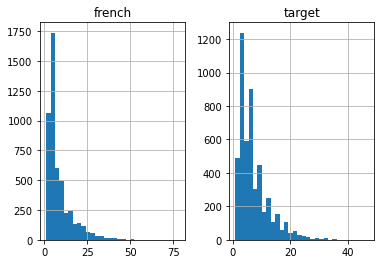

In [ ]:
fill_tab(french_tab, df_train,1)
fill_tab(target_tab, df_train,3)

length_df = pd.DataFrame({'french':french_tab, 'target':target_tab})
length_df.hist(bins=30)
plt.show()

The diagrams above show the maximum length of sentences in dataset :
##### So the length is 60 for the both (input and target languages)



### Now, we need to vectorize the sentences for transform that to entire sequences and we will fill these sequences with zero for all sequences so that the sentences have the same length.

In [ ]:
#this function allow to vectorize the sentences for language input and language target
def tokenisation(line_data):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(line_data)
  return tokenizer


In [ ]:
#prepare train french tokenizer
french_tokenizer = tokenisation(df_train.iloc[:,1])
french_vocab_size = len(french_tokenizer.word_index) + 1

french_length = 60
print('French lenght vocabilary : %d' % french_vocab_size)

## ewe french tab 1
target_tokenizer = tokenisation(df_train.iloc[:,3])
target_vocab_size = len(target_tokenizer.word_index) + 1

target_length = 60
print('Target lenght vocabilary : %d' % target_vocab_size)


French lenght vocabilary : 8830
Target lenght vocabilary : 7538


Remember that we are using seq2seq model.
Let create a function which will prepare the sequences and will fill the sequences up to the max length.

In [ ]:
#encoder sequences and fill sequence
def encode_sequence(tokenizer, length, lines):
  # integer encode sequences
  seq = tokenizer.texts_to_sequences(lines)
  # pad sequences with 0 values
  seq = pad_sequences(seq, maxlen=length, padding='post')
  return seq

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_train, test_size=0.2, random_state=12)

## 2. Building Model


because our data is already splitted, we need now to prepare it(data) for encoding.
 ##### We are going to encoding french train data and train fong-ewe data like input sequences; and test french data like target.

In [ ]:
#train data
trainX = encode_sequence(french_tokenizer, french_length, train.iloc[:,1])
trainY = encode_sequence(target_tokenizer, target_length, train.iloc[:,3])

#validation data
testX = encode_sequence(french_tokenizer, french_length, test.iloc[:,1])
testY = encode_sequence(target_tokenizer, target_length, test.iloc[:,3])

We’ll start off by defining our Seq2Seq model architecture:

  ###### For the encoder, we will use an embedding layer and an LSTM layer
  ###### For the decoder, we will use another LSTM layer followed by a dense layer


In [ ]:
# build NMT model
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
  model = Sequential()
  model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
  model.add(LSTM(units))
  model.add(RepeatVector(out_timesteps))
  model.add(LSTM(units, return_sequences=True))
  model.add(Dense(out_vocab, activation='softmax'))
  return model

We are using the RMSprop optimizer in this model as it’s usually a good choice when working with recurrent neural networks.

In [ ]:
# model compilation
model = define_model(french_vocab_size,target_vocab_size, french_length, target_length, 512)

In [ ]:
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

Please note that we have used ‘sparse_categorical_crossentropy‘ as the loss function. This is because the function allows us to use the target sequence as is, instead of the one-hot encoded format. One-hot encoding the target sequences using such a huge vocabulary might consume our system’s entire memory.

We are all set to start training our model!

We will train it for 5 epochs and with a batch size of 512 with a validation split of 20%. 80% of the data will be used for training the model and the rest for evaluating it.

We will also use the ModelCheckpoint() function to save the model with the lowest validation loss. 

In [ ]:
filename = 'model.frenc.ewe.fongbe'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=5, batch_size=512, validation_split = 0.2,callbacks=[checkpoint], 
                    verbose=1)

Epoch 1/5
7/7 [==============================] - ETA: 0s - loss: 4.6111 
Epoch 1: val_loss improved from inf to 1.22961, saving model to model.frenc.ewe.fongbe


INFO:tensorflow:Assets written to: model.frenc.ewe.fongbe/assets


INFO:tensorflow:Assets written to: model.frenc.ewe.fongbe/assets


7/7 [==============================] - 218s 30s/step - loss: 4.6111 - val_loss: 1.2296
Epoch 2/5
7/7 [==============================] - ETA: 0s - loss: 1.1903 
Epoch 2: val_loss improved from 1.22961 to 1.09991, saving model to model.frenc.ewe.fongbe


INFO:tensorflow:Assets written to: model.frenc.ewe.fongbe/assets


INFO:tensorflow:Assets written to: model.frenc.ewe.fongbe/assets


7/7 [==============================] - 211s 30s/step - loss: 1.1903 - val_loss: 1.0999
Epoch 3/5
7/7 [==============================] - ETA: 0s - loss: 1.1110 
Epoch 3: val_loss improved from 1.09991 to 1.05392, saving model to model.frenc.ewe.fongbe


INFO:tensorflow:Assets written to: model.frenc.ewe.fongbe/assets


INFO:tensorflow:Assets written to: model.frenc.ewe.fongbe/assets


7/7 [==============================] - 211s 30s/step - loss: 1.1110 - val_loss: 1.0539
Epoch 4/5
7/7 [==============================] - ETA: 0s - loss: 1.0968 
Epoch 4: val_loss did not improve from 1.05392
7/7 [==============================] - 194s 27s/step - loss: 1.0968 - val_loss: 1.0548
Epoch 5/5
7/7 [==============================] - ETA: 0s - loss: 1.0499 
Epoch 5: val_loss did not improve from 1.05392
7/7 [==============================] - 198s 28s/step - loss: 1.0499 - val_loss: 1.1648


In [ ]:
history.history

{'loss': [4.611130237579346,
  1.1902943849563599,
  1.1109504699707031,
  1.0967762470245361,
  1.0498898029327393],
 'val_loss': [1.2296128273010254,
  1.099910855293274,
  1.0539233684539795,
  1.0548295974731445,
  1.1648344993591309]}

Let’s compare the training loss and the validation loss.

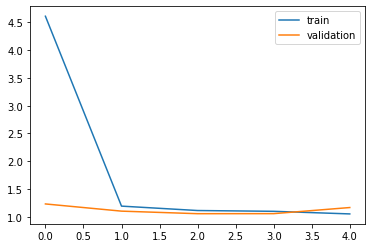

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

As you can see in the above plot, the validation loss stopped decreasing after 2 epochs. Here we have reduce number of epochs according to data reduced.

Finally, we can load the saved model and make predictions on the unseen data – testX.

In [ ]:
model = load_model('model.frenc.ewe.fongbe')
#preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

predict_x = model.predict(testX.reshape((testX.shape[0],testX.shape[1]))) 
classes_x = np.argmax(predict_x,axis=1)

These predictions are sequences of integers. We need to convert these integers to their corresponding words. Let’s define a function to do this:

In [ ]:
def get_word(n, tokenizer):
  for word, index in tokenizer.word_index.items():
    if index == n:
      return word
  return None

In [ ]:
classes_x.shape

(1000, 7538)

Convert predictions into text (Fong-Ewe):

In [ ]:
preds_text = []
for i in classes_x:
  print("i : ",i)
  temp = []
  for j in range(len(i)):
    t = get_word(i[j], target_tokenizer)
    if j > 0:
      if (t == get_word(i[j-1], target_tokenizer)) or (t == None):
            temp.append('')
      else:
            temp.append(t)
    else:
      if(t == None):
            temp.append('')
      else:
            temp.append(t) 

  preds_text.append(' '.join(temp))

i :  [59  7  3 ...  0  0  0]
i :  [56  2  2 ...  0  0  0]
i :  [59  2  2 ...  0  0  0]
i :  [59  7  3 ...  0  0  0]
i :  [59  4  2 ...  0  0  0]
i :  [59  4  4 ...  0  2  0]
i :  [59  7  3 ...  0  0  0]
i :  [59  5  4 ...  0  2  0]
i :  [59  6  3 ...  0  0  0]
i :  [59  7  3 ...  0  0  0]
i :  [59  7  3 ...  0  0  0]
i :  [59  7  3 ...  0  0  0]
i :  [59  3  3 ...  0  1  0]
i :  [59  5  5 ...  0  3  0]
i :  [56  2  2 ...  0  0  0]
i :  [59  7  3 ...  0  0  0]
i :  [59  3  2 ...  0  0  0]
i :  [59  7  7 ...  0  5  0]
i :  [59  2  2 ...  0  0  0]
i :  [59  2  2 ...  0  0  0]
i :  [59  5  2 ...  0  0  0]
i :  [59  2  2 ...  0  0  0]
i :  [59  2  2 ...  0  0  0]
i :  [59  3  3 ...  0  1  0]
i :  [59  2  2 ...  0  0  0]
i :  [59  2  2 ...  0  1  0]
i :  [59  7  3 ...  0  0  0]
i :  [59  7  3 ...  0  0  0]
i :  [59  3  2 ...  0  1  0]
i :  [59  2  2 ...  0  0  0]
i :  [59  6  3 ...  0  0  0]
i :  [59  7  3 ...  0  0  0]
i :  [59  5  2 ...  0  0  0]
i :  [59  6  3 ...  0  0  0]
i :  [59  3  3

Let’s put the original Ewe-Fongbe sentences in the test dataset and the predicted sentences in a dataframe:

In [ ]:
pred_df = pd.DataFrame({'actual' : df_test.iloc[:1000,1], 'predicted' : preds_text})

We can randomly print some actual vs predicted instances to see how our model performs:

In [ ]:
# print 15 rows randomly
pred_df.sample(30)

,actual,predicted
357,"Je ne suis pas devenue fondatrice de projet, je le fais tout en étant juriste et bloggeuse, aucune fonction n’a jamais empêché d’en faire une autre, et justement le défi motive",à e le e le e le e le e le e le e le e le e le e le e le e le e le e le e le e le e le e le e le e le e le e le e le e le e le e le e le e le...
410,"Par exemple, pour l’huile de coco, j’allais vers les productrices, je voyais comment elles procédaient, et aujourd’hui je la produis moi-même pour mes produits",à e le e le e le e le e le e le e le e le e le e le e le e le e le e le e le e le e le e le e le e le e le e le e le e le e le e le e le e le e le e le le le ...
67,"Moi, je notais tout ce qu’elle disait dans un petit carnet noir",à e le e le e le e le e le e le e le e le e le e le e le e le e le e le e le e le e le e le e le e le e le e le e le e le e le ...
188,C’est à cause de votre divergence que les autres trouvent raison de nous critiquer,à e le e le e le e le e le e le e le e le e le e le e le e le e le e le e le e le e le e le e le e le e le e le e le e le e le e le e le e le e le e le ...
642,La vie m’en a privé en m’incitant à pleurer,à ɔ ɖo be ɔ e be la be e nu la na nu be ɔ be na be na be ɖo be na be na be na be na be ɔ na ɔ ɖo na nu na be nu na nu ɔ nu na ɔ na ɖo be nu be e na e nu be ɔ ɖo na e be na be e nu be ɖo na e nu na ɖo na e nu ɖo nu na nu ɖo na e na nu na le e be nu e na be ɖo na ɖo nu e nu ɖo e na ɖo le e ɖo na nu e le e ɖo nu ɖo e nu ɖo na e ɖo e ɖo nu e be na ɖo e ɖo le ɖo e...
588,"Il y a une phrase qui m’a marquée dans l’une des chansons de ton album, « L’espoir fait vivre,mais on ne peut pas vivre d’espoir sinon au Togo, on serait immortel »…",à be ɖo be na be e na ɔ be e nu ɔ nu na be na nu be e na nu na nu na be nu na be ɖo na nu na nu ɖo be nu ɖo nu be na ɖo be ɖo na e nu e ɖo na be ɖo nu na e na nu na e nu na e nu e ɖo nu ɖo nu e nu e ɖo nu ɖo e nu e nu le e na ɖo nu e na ɖo nu e nu ɖo e nu e nu ɖo le e ɖo na ɖo le e ɖo nu ɖo e ɖo nu e ɖo le na nu ɖo e ɖo e le ɖo e ɖo e le ɖo nu e ...
565,10 000 FCFA ou moins / mois,à na e nu na e nu be nu e ɖo na nu ɖo nu na nu ɖo nu e nu ɖo nu na ɖo nu na e nu ɖo nu ɖo nu ɖo na nu e nu ɖo nu e ɖo e ɖo nu na e ɖo nu e nu ɖo nu e ɖo nu e ɖo e ɖo nu ɖo e ɖo e ɖo e ɖo e ɖo le e nu ɖo e nu e nu ɖo e ɖo e ɖo e le ɖo e le e nu ɖo le e ɖo e ɖo le e ɖo le nu ɖo le e le e le e ɖo e le e le ɖo e ɖo e ɖo e le e ...
960,dire les choses telles qu’elles sont‚ de désigner les choses par leurs noms.,à ɔ ɖo be ɔ e be la be e nu la na nu be ɔ be na be na be ɖo be na be na be na be na be ɔ na ɔ ɖo na nu na be nu na nu ɔ nu na ɔ na ɖo be nu be e na e nu be ɔ ɖo na e be na be e nu be ɖo na e nu na ɖo na e nu ɖo nu na nu ɖo na e na nu na le e be nu e na be ɖo na ɖo nu e nu ɖo e na ɖo le e ɖo na nu e le e ɖo nu ɖo e nu ɖo na e ɖo e ɖo nu e be na ɖo e ɖo le ɖo e...
691,"Par exemple, en 2014-2015 j’ai enseigné au petit frère de mon mentor tout ce que je savais et il est très bon aujourd’hui",à ɔ ɖo be ɔ e be la be e nu la na nu be ɔ be na be na be ɖo be na be na be na be na be ɔ na ɔ ɖo na nu na be nu na nu ɔ nu na ɔ na ɖo be nu be e na e nu be ɔ ɖo na e be na be e nu be ɖo na e nu na ɖo na e nu ɖo nu na nu ɖo na e na nu na le e be nu e na be ɖo na ɖo nu e nu ɖo e na ɖo le e ɖo na nu e le e ɖo nu ɖo e nu ɖo na e ɖo e ɖo nu e be na ɖo e ɖo le ɖo e...
383,"Et pourquoi avez-vous besoin de le clamer à la face du monde, au travers de cette mélodie",à ɖo e ɖo e ɖo e ɖo e ɖo e ɖo e ɖo e ɖo e ɖo e ɖo e ɖo e ɖo e ɖo e ɖo e ɖo e ɖo e ɖo e ɖo e ɖo e ɖo e ɖo e le e le e le e ɖo e le e le e le e le e le e le ɖo e le e le e le e le e le e le e le e le e le e le e le e le e le e le e le e le e le e le e le e le e...


# For this project, we would like to signal that we have reduce the data size for training and testing our model because the data is to much and its does not allowed to train all data; in final the training crashed.